## Aprendizaje automático relacional con extraacción manual de características

Librerías

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split, GridSearchCV


## Data import

In [3]:
X = pd.read_csv("../data/processed/X.csv")

target = pd.read_csv("../data/raw/musae_git_target.csv")
y = pd.Categorical(target["ml_target"])

In [ ]:
from sklearn.manifold import MDS
# Apply t-SNE transformation on node embeddings
mds = MDS(n_components=2)
embedding_2d = mds.fit_transform(X)

In [ ]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=y,
    cmap="jet",
    alpha=alpha,
)

In [4]:
y.value_counts()/len(y)

# dataset no balanceado... problemas

0    0.741671
1    0.258329
Name: count, dtype: float64

In [ ]:
X.describe()

Partición entrenamiento - test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [6]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek

# # X_train_resamp, y_train_resamp = SMOTE().fit_resample(X_train,y_train)
X_train_oversamp, y_train_oversamp = ADASYN().fit_resample(X_train,y_train)


# # X_train_undersamp, y_train_undersamp = RandomUnderSampler().fit_resample(X_train,y_train)
# # X_train_undersamp, y_train_undersamp = ClusterCentroids().fit_resample(X_train,y_train)
nm1 = NearMiss(version=1)
X_train_undersamp, y_train_undersamp = nm1.fit_resample(X_train,y_train)

X_train_samp, y_train_samp = SMOTEENN().fit_resample(X_train,y_train)
# # X_train_samp, y_train_samp = SMOTETomek().fit_resample(X_train,y_train)

In [8]:
from collections import Counter

print(Counter(y_train).items())
print(Counter(y_train_undersamp).items())

dict_items([(0, 18750), (1, 6509)])
dict_items([(np.int64(0), 6509), (np.int64(1), 6509)])


## Decision Tree

In [85]:
dt = tree.DecisionTreeClassifier()

In [86]:
param_grid = dict(max_depth = list(range(3,15)))
grid = GridSearchCV(dt, param_grid, cv = 10, scoring="accuracy")

In [87]:
grid.fit(X_train_resamp,y_train_resamp)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14]},
             scoring='accuracy')

In [88]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.647045,0.021536,{'max_depth': 3}
1,0.637812,0.039289,{'max_depth': 4}
2,0.660302,0.047440,{'max_depth': 5}
3,0.675074,0.057814,{'max_depth': 6}
4,0.683751,0.061645,{'max_depth': 7}
5,0.709223,0.075384,{'max_depth': 8}
6,0.716596,0.080851,{'max_depth': 9}
7,0.720056,0.083594,{'max_depth': 10}
8,0.725778,0.083579,{'max_depth': 11}
9,0.723995,0.086680,{'max_depth': 12}


Text(0, 0.5, 'cv_accuracy')

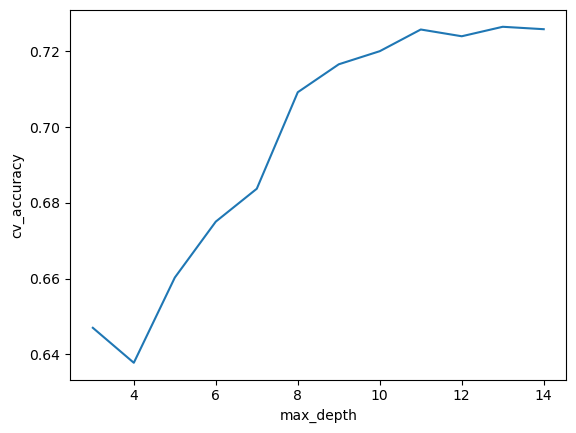

In [89]:
plt.plot(grid.cv_results_["param_max_depth"],grid.cv_results_["mean_test_score"])
plt.xlabel("max_depth")
plt.ylabel("cv_accuracy")

In [71]:
# dt = tree.DecisionTreeClassifier(max_depth=grid.best_params_["max_depth"])
# dt.fit(X_train,y_train)
# plt.figure(figsize=(12,12))
# tree.plot_tree(dt)

Evaluación

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [13]:
def plot_confusion_matrix(cm, target_labels, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_labels))
    plt.xticks(tick_marks, target_labels, rotation=45)
    plt.yticks(tick_marks, target_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


0.6983361466120087


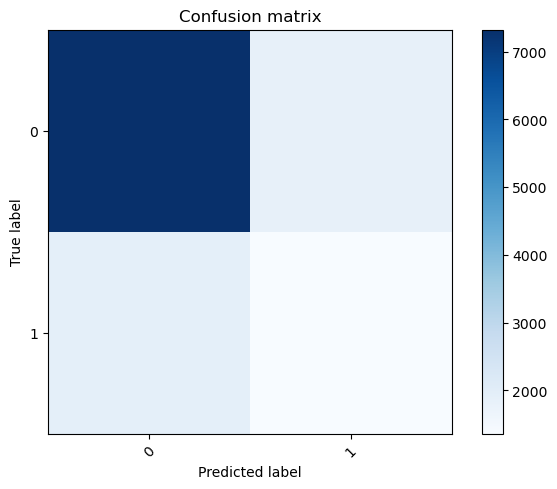

In [90]:



y_pred = grid.predict(X_test)

print(accuracy_score(y_true= y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred)


plot_confusion_matrix(confu_mat,[0,1])

In [60]:
y.value_counts()

0    27961
1     9739
Name: count, dtype: int64

## Random forest

In [140]:
rf = RandomForestClassifier()

In [141]:
param_grid = dict(max_depth = list(range(3,10)), n_estimators = [10,50,100,200])
grid = GridSearchCV(rf, param_grid, cv = 10, scoring="accuracy")

In [151]:
rf = RandomForestClassifier()

In [152]:
rf.fit(X_train_samp,y_train_samp)
# rf.fit(X_train_undersamp,y_train_undersamp)
# rf.fit(X_train_oversamp,y_train_oversamp)
# rf.fit(X_train,y_train)



RandomForestClassifier()

0.713929748412507
[[0.79 0.21]
 [0.49 0.51]]


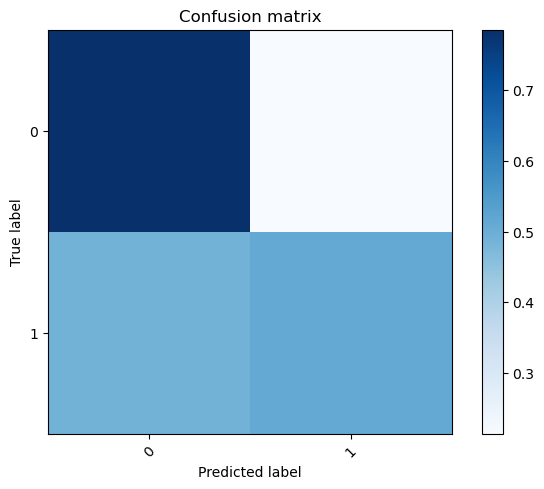

In [153]:
y_pred = rf.predict(X_test)

print(accuracy_score(y_true= y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred,normalize="true")
print(confu_mat.round(2))
plot_confusion_matrix(confu_mat,[0,1])


## SVM

In [ ]:
svc = SVC()

param_grid = dict(kernel = ["linear", "poly","rbf","sigmoid"] )
grid = GridSearchCV(svc,param_grid, cv = 2, scoring="accuracy")

grid.fit(X_train_undersamp,y_train_undersamp)
# svc.fit(X_train_samp,y_train_samp)
# svc.fit(X_train_oversamp,y_train_oversamp)
# svc.fit(X_train,y_train)

y_pred = grid.predict(X_test)

NameError: name 'accuracy_score' is not defined

0.49666425528494496
[[0.49 0.51]
 [0.5  0.5 ]]


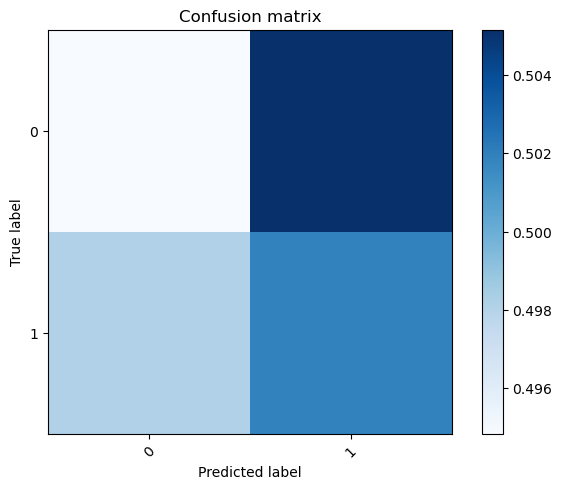

In [14]:
print(accuracy_score(y_true= y_test,y_pred=y_pred))
confu_mat = confusion_matrix(y_true= y_test,y_pred=y_pred,normalize="true")
print(confu_mat.round(2))
plot_confusion_matrix(confu_mat,[0,1])

## DNN